In [ ]:
! pip install pulp

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import pulp
import numpy as np
import sklearn.metrics as metrics
import requests
import pandas as pd
import seaborn as sns


def Access_URL(url):
    r = requests.get(url) 
    json = r.json() 
    return json 

def plot_top_managers(team_ids = range(1, 1000, 1)):
    sns.set()
    overall_dataframe = pd.DataFrame()
    for id in team_ids:
        previous_seasons = Access_URL(f'https://fantasy.premierleague.com/api/entry/{id}/history/')['past']
        df_player = pd.DataFrame(previous_seasons)
        df_player['id'] = id
        overall_dataframe = pd.concat([overall_dataframe, df_player])
    last_season = overall_dataframe.loc[overall_dataframe['season_name'] == '2020/21']
    last_season.plot(kind='scatter', x='total_points', y='rank', figsize=(10, 10))
    mask = (last_season['total_points'] >= 2400) 
    last_season.loc[mask].plot(kind='scatter', x='total_points', y='rank', figsize=(10, 10))
    
def regression_results(y_true, y_pred):
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
def get_repeat(use, round):
    # Testing the designed modesl
    df = pd.read_csv('/content/drive/MyDrive/Data/all_preds.csv') # sorted by season, gameweek, name and kickoff time
    df_idx = pd.read_csv('/content/drive/MyDrive/Data/collected_us_updated.csv').sort_values(by = ['season', 'GW', 'player_name', 'kickoff_time'])
    df_idx = df_idx[df_idx['season'] == 2020]
    df_idx.reset_index(drop = True, inplace = True)
    if round:
            df[use] = df[use].round(1)
    for name in ['value', 'position', 'team', 'kickoff_time', 'total_points']:
        df[name] = df_idx[name]
    names = pd.DataFrame({'player_name': df['player_name'].unique()})
    df_repeated = pd.concat([names]*38, ignore_index=True) 
    df_repeated['GW'] = np.repeat(range(1, 39), names.shape[0]) # Contains all names duplicated 38 times
    df_repeated = pd.merge(df_repeated, df, on = ['player_name', 'GW'], how = 'outer') # Get player stats
    for col in ['total_points', use]:
        df_repeated[col] = df_repeated.groupby(['player_name', 'GW'])[col].transform('sum') # Merge double weeks
        df_repeated.drop_duplicates(['player_name', 'GW', col], inplace = True)
        df_repeated[col].fillna(0, inplace = True) # Dont want these players
    f = lambda x: x.median() if np.issubdtype(x.dtype, np.number) else x.mode().iloc[0]
    df_repeated = df_repeated.fillna(df_repeated.groupby('player_name').transform(f)) 
    df_repeated.sort_values(['GW', 'player_name']).reset_index(drop = True, inplace = True)
    return df_repeated

def select_team(expected_scores, prices, positions, clubs, total_budget=100, sub_factor=0.2):
    """[Function to pick a starting XV]
    Args:
        expected_scores ([type]): [description]
        prices ([type]): [description]
        positions ([type]): [description]
        clubs ([type]): [description]
        total_budget (int, optional): [description]. Defaults to 100.
        sub_factor (float, optional): [description]. Defaults to 0.2.
    Returns:
        [type]: [description]
    """    
    num_players = len(expected_scores)
    model = pulp.LpProblem("Constrained_Value_Maximisation", pulp.LpMaximize)
    decisions = [pulp.LpVariable("x{}".format(i), lowBound=0, upBound=1, cat='Integer') for i in range(num_players)]
    captain_decisions = [pulp.LpVariable("y{}".format(i), lowBound=0, upBound=1, cat='Integer') for i in range(num_players)]
    sub_decisions = [pulp.LpVariable("z{}".format(i), lowBound=0, upBound=1, cat='Integer') for i in range(num_players)]

    # objective function:
    model += sum((captain_decisions[i] + decisions[i] + sub_decisions[i]*sub_factor) * expected_scores[i] for i in range(num_players)), "Objective"

    # cost constraint
    model += sum((decisions[i] + sub_decisions[i]) * prices[i] for i in range(num_players)) <= total_budget  # total cost

    # position constraints
    # 1 starting goalkeeper
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 'GK') == 1
    # 2 total goalkeepers
    model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 'GK') == 2

    # 3-5 starting defenders
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 'DEF') >= 3
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 'DEF') <= 5
    
    # 5 total defenders
    model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 'DEF') == 5

    # 3-5 starting midfielders
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 'MID') >= 3
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 'MID') <= 5
    
    # 5 total midfielders
    model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 'MID') == 5

    # 1-3 starting attackers
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 'FWD') >= 1
    model += sum(decisions[i] for i in range(num_players) if positions[i] == 'FWD') <= 3
    # 3 total attackers
    model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if positions[i] == 'FWD') == 3

    # club constraint
    for club_id in np.unique(clubs):
        model += sum(decisions[i] + sub_decisions[i] for i in range(num_players) if clubs[i] == club_id) <= 3  # max 3 players

    model += sum(decisions) == 11  # total team size
    model += sum(captain_decisions) == 1  # 1 captain
    
    for i in range(num_players):  
        model += (decisions[i] - captain_decisions[i]) >= 0  # captain must also be on team
        model += (decisions[i] + sub_decisions[i]) <= 1  # subs must not be on team

    model.solve()
    # print("Total expected score = {}".format(model.objective.value()))
    return decisions, captain_decisions, sub_decisions


def get_starting_XV(df_repeated, GW = 1, max_budget = 100):
    df =  df_repeated[df_repeated['GW'] == GW].reset_index(drop = True)
    expected_scores = df[use] 
    actual_scores = df['total_points']
    prices = df["value"] /10
    positions = df["position"]
    clubs = df["team"]
    decisions, captain_decisions, sub_decisions = select_team(expected_scores.values, prices.values, positions.values, clubs.values, total_budget=max_budget)
    squad_indices, starting_indices, sub_indices, captain_indice = [],[],[],[]
    print(f'Gameweek: {GW}')
    for i in range(len(decisions)):
        if decisions[i].value() == 1:
            if captain_decisions[i].value() == 1:
                captain_indice.append(i) 
            squad_indices.append(i)
            starting_indices.append(i)
    for i in range(len(sub_decisions)):
        if sub_decisions[i].value() == 1:
            squad_indices.append(i)
            sub_indices.append(i)
    actual_max_budget = 100
    budget = round(actual_max_budget - prices.iloc[squad_indices].sum(), 2)
    exp_captain_point = expected_scores.iloc[captain_indice].sum()*2 if GW in TRIPLE_CAPTAIN else expected_scores.iloc[captain_indice].sum()
    act_captain_point = actual_scores.iloc[captain_indice].sum()*2 if GW in TRIPLE_CAPTAIN else actual_scores.iloc[captain_indice].sum()
    actual_points = round(actual_scores.iloc[squad_indices].sum() + act_captain_point, 2) if GW in BENCH_BOOST else round(actual_scores.iloc[starting_indices].sum() +  act_captain_point, 2)
    ex_pts = round(expected_scores.iloc[squad_indices].sum() + exp_captain_point, 2) if GW in BENCH_BOOST else round(expected_scores.iloc[starting_indices].sum()  + exp_captain_point, 2)
    # print(f'Starting budget: {max_budget}')
    # print('Budget left:', budget, end = '\n')
    # print(f'Expected scored = {expected_scores.iloc[starting_indices].sum()} + {expected_scores.iloc[captain_indice].sum()} = {ex_pts}') 
    # print(f'Points scored = {actual_scores.iloc[starting_indices].sum()}  + {actual_scores.iloc[captain_indice].sum()} = {actual_points}') 
    return squad_indices, starting_indices, sub_indices, captain_indice, budget, actual_points, ex_pts, exp_captain_point, act_captain_point

def get_decision_array(name, length):
    return np.array([
        pulp.LpVariable("{}_{}".format(name, i), lowBound=0, upBound=1, cat='Integer')
        for i in range(length)
    ])

class TransferOptimiser:
    def __init__(self, expected_scores, buy_prices, sell_prices, positions, clubs):
        self.expected_scores = expected_scores
        self.buy_prices = buy_prices
        self.sell_prices = sell_prices
        self.positions = positions
        self.clubs = clubs
        self.num_players = len(expected_scores)

    def instantiate_decision_arrays(self):
        # we will make transfers in and out of the squad, and then pick subs and captains from that squad
        transfer_in_decisions_free = get_decision_array("transfer_in_free", self.num_players)
        transfer_in_decisions_paid = get_decision_array("transfer_in_paid", self.num_players)
        transfer_out_decisions = get_decision_array("transfer_out_paid", self.num_players)
        # total transfers in will be useful later
        transfer_in_decisions = transfer_in_decisions_free + transfer_in_decisions_paid
        sub_decisions = get_decision_array("subs", self.num_players)
        captain_decisions = get_decision_array("captain", self.num_players)
        return transfer_in_decisions_free, transfer_in_decisions_paid, transfer_out_decisions, transfer_in_decisions, sub_decisions, captain_decisions

    def encode_player_indices(self, indices):
        decisions = np.zeros(self.num_players)
        decisions[indices] = 1
        return decisions

    def apply_transfer_constraints(self, model, transfer_in_decisions_free, transfer_in_decisions, transfer_out_decisions, budget_now):
        # only 1 free transfer
        model += sum(transfer_in_decisions_free) <= 1
        # budget constraint
        transfer_in_cost = sum(transfer_in_decisions * self.buy_prices)
        transfer_out_cost = sum(transfer_out_decisions * self.sell_prices)
        budget_next_week = budget_now + transfer_out_cost - transfer_in_cost
        model += budget_next_week >= 0

    def solve(self, current_squad_indices, budget_now, sub_factor, GW):
        current_squad_decisions = self.encode_player_indices(current_squad_indices)

        model = pulp.LpProblem("Transfer_Optimisation", pulp.LpMaximize)
        transfer_in_decisions_free, transfer_in_decisions_paid, transfer_out_decisions, transfer_in_decisions, sub_decisions, captain_decisions = self.instantiate_decision_arrays()

        # calculate new team from current team + transfers
        next_week_squad = current_squad_decisions + transfer_in_decisions - transfer_out_decisions
        starters = next_week_squad - sub_decisions

        # points penalty for additional transfers
        transfer_penalty =  sum(transfer_in_decisions_paid) * 4 # 4-pt incremental hit

        self.apply_transfer_constraints(model, transfer_in_decisions_free, transfer_in_decisions, transfer_out_decisions, budget_now)
        self.apply_formation_constraints(model, squad=next_week_squad, starters=starters, subs=sub_decisions, captains=captain_decisions)

        # objective function:
        model += self.get_objective(starters, sub_decisions, captain_decisions, sub_factor, transfer_penalty, self.expected_scores), "Objective"
        status = model.solve()

        return transfer_in_decisions, transfer_out_decisions, starters, sub_decisions, captain_decisions

    def get_objective(self, starters, subs, captains, sub_factor, transfer_penalty, scores):
        """[Maximize points scored by starters, substitutions, captains subtracted by the transfer penalty]
        Args:
            starters ([type]): [description]
            subs ([type]): [description]
            captains ([type]): [description]
            sub_factor ([type]): [description]
            transfer_penalty ([type]): [description]
            scores ([type]): [description]
        Returns:
            [type]: [description]
        """        
        
        captain_points = sum(captains * scores)
        starter_points = sum(starters * scores)
        if GW in BENCH_BOOST:
            sub_points = sum(subs * scores) 
        else:
            sub_points = sum(subs * scores) * sub_factor
        if GW in WILDCARD + FREE_HIT:
            objective = starter_points + sub_points + captain_points
        elif GW in TRIPLE_CAPTAIN:
            objective = starter_points + sub_points + captain_points + captain_points - transfer_penalty
        elif GW in BENCH_BOOST:
            objective = starter_points + sub_points/sub_factor + captain_points - transfer_penalty
        else:
            objective = starter_points + sub_points + captain_points - transfer_penalty
            
            
        return objective

    def apply_formation_constraints(self, model, squad, starters, subs, captains):
        position_data = {
                        "gk": {"position_id": 'GK', "min_starters": 1, "max_starters": 1, "num_total": 2},
                        "df": {"position_id": 'DEF', "min_starters": 3, "max_starters": 5, "num_total": 5},
                        "mf": {"position_id": 'MID', "min_starters": 3, "max_starters": 5, "num_total": 5},
                        "fw": {"position_id": 'FWD', "min_starters": 1, "max_starters": 3, "num_total": 3}
                        }
        for position, data in position_data.items():
            # formation constraints
            model += sum(starter for starter, position in zip(starters, self.positions) if position == data["position_id"]) >= data["min_starters"]
            model += sum(starter for starter, position in zip(starters, self.positions) if position == data["position_id"]) <= data["max_starters"]
            model += sum(selected for selected, position in zip(squad, self.positions) if position == data["position_id"]) == data["num_total"]

        # club constraint
        for club_id in np.unique(self.clubs):
            model += sum(selected for selected, club in zip(squad, self.clubs) if club == club_id) <= 3  # max 3 players

        # total team size
        model += sum(starters) == 11
        model += sum(squad) == 15
        model += sum(captains) == 1

        for i in range(self.num_players):
            model += (starters[i] - captains[i]) >= 0  # captain must also be on team
            model += (starters[i] + subs[i]) <= 1  # subs must not be on team

def manage_squad(df_repeated, GW, squad_indices, budget = 0):
    df =  df_repeated[df_repeated['GW'] == GW].reset_index(drop = True)
    actual_scores = df['total_points']
    expected_scores = df[use]
    prices = df["value"] /10
    old_price = round(prices.iloc[squad_indices].sum(), 2)
    positions = df["position"]
    clubs = df["team"]
    opt = TransferOptimiser(expected_scores.values, prices.values, prices.values, positions.values, clubs.values)
    transfer_in_decisions, transfer_out_decisions, decisions, sub_decisions, captain_decisions = opt.solve(squad_indices, budget_now=budget, sub_factor=0.2, GW = GW)
    squad_indices, starting_indices, sub_indices, captain_indice, p_out, p_in = [], [], [], [], [], []
    print(f'Gameweek: {GW}', end = '\n')
    for i in range(len(decisions)):
        if decisions[i].value() == 1:
            squad_indices.append(i)
            starting_indices.append(i)
            if captain_decisions[i].value() == 1:
                captain_indice.append(i)
    for i in range(len(sub_decisions)):
        if sub_decisions[i].value() == 1:
            squad_indices.append(i)
            sub_indices.append(i)
    for i in range(len(transfer_out_decisions)):
        if transfer_out_decisions[i].value() == 1:
            p_out.append(prices.iloc[i])
    for i in range(len(transfer_in_decisions)):
        if transfer_in_decisions[i].value() == 1:
            p_in.append(prices.iloc[i])
            
    # Chips
    # Wildcard + free hit
    transfers = len(p_in)

    if GW in WILDCARD + FREE_HIT:
        penalty = 0
    else:
        penalty = ((len(p_in) - 1) * 4)
    # Triple captain
    
    if GW in TRIPLE_CAPTAIN:
        exp_captain_point = expected_scores.iloc[captain_indice].sum()*2
        act_captain_point = actual_scores.iloc[captain_indice].sum()*2 # Note the captains points are already added once
    else:
        exp_captain_point = expected_scores.iloc[captain_indice].sum()
        act_captain_point = actual_scores.iloc[captain_indice].sum()
        
    if GW in BENCH_BOOST:
        ex_pts = round(expected_scores.iloc[squad_indices].sum() - penalty + exp_captain_point, 2)
        actual_points = round(actual_scores.iloc[squad_indices].sum() - penalty + act_captain_point, 2)
    else:
        ex_pts = round(expected_scores.iloc[starting_indices].sum() - penalty + exp_captain_point, 2)
        actual_points = round(actual_scores.iloc[starting_indices].sum() - penalty + act_captain_point, 2)
    budget_new = round(old_price - prices.iloc[squad_indices].sum() + budget, 2)
    # print('Starting budget', budget)
    # print('Transferred', len(p_out), 'players out for ', '+', round(sum(p_out), 2))
    # print('Transferred', len(p_in), 'players in at ', '-', round(sum(p_in), 2))
    # print(f'Expected scored = {expected_scores.iloc[starting_indices].sum()} - {penalty} + {exp_captain_point} = {ex_pts}') 
    # print(f'Points scored = {actual_scores.iloc[starting_indices].sum()} - {penalty} + {act_captain_point} = {actual_points}') 
    # print(f'Budget left = {old_price} - {round(prices.iloc[squad_indices].sum(), 2)} + {budget} = {budget_new}', end = '\n')
    return squad_indices, starting_indices, sub_indices, captain_indice, budget_new, actual_points, ex_pts, exp_captain_point, act_captain_point, transfers, penalty

def format_squad(df_repeated, starting_indices, captain_indice, sub_indices, budget,  transfers, GW, use, penalty): #updt
    df =  df_repeated[df_repeated['GW'] == GW].reset_index(drop = True)
    actual_scores = df['total_points']
    expected_scores = df[use]
    prices = df["value"] /10
    old_price = round(prices.iloc[squad_indices].sum(), 2)
    positions = df["position"]
    clubs = df["team"]

    if GW in WILDCARD + FREE_HIT:
        penalty = 0
    else:
        penalty = ((len(p_in) - 1) * 4)

    if GW in TRIPLE_CAPTAIN:
        exp_captain_point = expected_scores.iloc[captain_indice].sum()*2
        act_captain_point = actual_scores.iloc[captain_indice].sum()*2 # Note the captains points are already added once
    else:
        exp_captain_point = expected_scores.iloc[captain_indice].sum()
        act_captain_point = actual_scores.iloc[captain_indice].sum()
        
    if GW in BENCH_BOOST:
        ex_pts = round(expected_scores.iloc[squad_indices].sum() - penalty + exp_captain_point, 2)
        actual_points = round(actual_scores.iloc[squad_indices].sum() - penalty + act_captain_point, 2)
    else:
        ex_pts = round(expected_scores.iloc[starting_indices].sum() - penalty + exp_captain_point, 2)
        actual_points = round(actual_scores.iloc[starting_indices].sum() - penalty + act_captain_point, 2)

    budget_new = round(old_price - prices.iloc[squad_indices].sum() + budget, 2)

    starters = df.iloc[starting_indices] 
    captain = df.iloc[captain_indice] 
    subs = df.iloc[sub_indices] 

    subs['sub'], starters['starter'], captain['captain']  = 1, 1, 1
    starters = pd.merge(starters, captain[['player_name', 'captain']], on = 'player_name', how = 'outer')
    squad = pd.concat([starters, subs])
    squad = squad.fillna(0).sort_values(['captain', 'starter', 'position', 'total_points'], ascending=False).reset_index(drop = True)
    squad['base_points'] = np.where(squad['starter'] == 1, squad.groupby('GW')['total_points'].transform('sum'), 0) 
    squad['wildcard'] = np.where(squad['GW'].isin(WILDCARD), 1, 0)
    squad['triple_captain'] = np.where(squad['GW'].isin(TRIPLE_CAPTAIN), 1, 0)
    squad['bench_boost'] = np.where(squad['GW'].isin(BENCH_BOOST), 1, 0)
    squad['penalty'] = penalty
    squad['actual_points'] = actual_points
    squad['remaining_budget'] = budget_new
    squad['expected_points'] = ex_pts
    squad['expected_captain_points'] = exp_captain_point
    squad['actual_captain_points'] = act_captain_point
    squad['transfers'] = transfers
    return squad


# As implemented, only one chip can be used/gameweek
WILDCARD = [0, 0] 
TRIPLE_CAPTAIN = [0]
BENCH_BOOST = [0]
FREE_HIT = [0]
BUDGET = 100
pd.options.mode.chained_assignment = None  # default='warn'

# Whether predictions should be rounded
round_preds = False
for use in ['LR', 'CBoost', 'SVR', 'KNN', 'MLP', 'Meta', 'H2O', 'Avg. Meta', 'Avg. Base']:
    total_points, squads = [], []
    df_repeated = get_repeat(use, round = round_preds) # Replicate all players`
    # Collect squad formulation and gameweek transfers
    for GW in range(1,39):
        if GW in FREE_HIT:
            reset_squad_indices, reset_starting_indices, reset_sub_indices, reset_captain_indice = squad_indices, starting_indices, sub_indices, captain_indice 
        # Main Loop
        if GW == 1:
            transfers, penalty = 0, 0
            squad_indices, starting_indices, sub_indices, captain_indice, budget, actual_points, ex_pts, exp_captain_point, act_captain_point =  get_starting_XV(df_repeated, max_budget = BUDGET, GW = GW) # For the first gameweek
        else:
            squad_indices, starting_indices, sub_indices, captain_indice, budget, actual_points,  ex_pts, exp_captain_point, act_captain_point, transfers, penalty = manage_squad(df_repeated, GW, squad_indices, budget)
        squad = format_squad(df_repeated, starting_indices, captain_indice, sub_indices, budget,  transfers, GW, use, penalty)
        squads.append(squad)
        total_points.append(actual_points)
        if GW in FREE_HIT:
            squad_indices, starting_indices, sub_indices, captain_indice = reset_squad_indices, reset_starting_indices, reset_sub_indices, reset_captain_indice 
    print(use)
    print(f'Total season points (including penalty, double captain, and chips): {sum(total_points)}')
    df = pd.concat(squads) 
    df.to_csv(f'/content/drive/MyDrive/teams/squad_transfers_{use}_{round_preds}.csv', index = False)

Gameweek: 1
Gameweek: 2
Gameweek: 3
Gameweek: 4
Gameweek: 5
Gameweek: 6
Gameweek: 7
Gameweek: 8
Gameweek: 9
Gameweek: 10
Gameweek: 11
Gameweek: 12
Gameweek: 13
Gameweek: 14
Gameweek: 15
Gameweek: 16
Gameweek: 17
Gameweek: 18
Gameweek: 19
Gameweek: 20
Gameweek: 21
Gameweek: 22
Gameweek: 23
Gameweek: 24
Gameweek: 25
Gameweek: 26
Gameweek: 27
Gameweek: 28
Gameweek: 29
Gameweek: 30
Gameweek: 31
Gameweek: 32
Gameweek: 33
Gameweek: 34
Gameweek: 35
Gameweek: 36
Gameweek: 37
Gameweek: 38
LR
Total season points (including penalty, double captain, and chips): 2063
Gameweek: 1
Gameweek: 2
Gameweek: 3
Gameweek: 4
Gameweek: 5
Gameweek: 6
Gameweek: 7
Gameweek: 8
Gameweek: 9
Gameweek: 10
Gameweek: 11
Gameweek: 12
Gameweek: 13
Gameweek: 14
Gameweek: 15
Gameweek: 16
Gameweek: 17
Gameweek: 18
Gameweek: 19
Gameweek: 20
Gameweek: 21
Gameweek: 22
Gameweek: 23
Gameweek: 24
Gameweek: 25
Gameweek: 26
Gameweek: 27
Gameweek: 28
Gameweek: 29
Gameweek: 30
Gameweek: 31
Gameweek: 32
Gameweek: 33
Gameweek: 34
Gamewe

In [ ]:
# As implemented, only one chip can be used/gameweek
WILDCARD = [18, 29] 
TRIPLE_CAPTAIN = [14]
BENCH_BOOST = [35]
FREE_HIT = [0]
BUDGET = 100
pd.options.mode.chained_assignment = None  # default='warn'

# Whether predictions should be rounded
round_preds = False
for use in ['Meta', 'Avg. Base', 'MLP', 'CBoost', 'KNN']:
    total_points, squads = [], []
    df_repeated = get_repeat(use, round = round_preds) # Replicate all players`
    # Collect squad formulation and gameweek transfers
    for GW in range(1,39):
        if GW in FREE_HIT:
            reset_squad_indices, reset_starting_indices, reset_sub_indices, reset_captain_indice = squad_indices, starting_indices, sub_indices, captain_indice 
        # Main Loop
        if GW == 1:
            transfers, penalty = 0, 0
            squad_indices, starting_indices, sub_indices, captain_indice, budget, actual_points, ex_pts, exp_captain_point, act_captain_point =  get_starting_XV(df_repeated, max_budget = BUDGET, GW = GW) # For the first gameweek
        else:
            squad_indices, starting_indices, sub_indices, captain_indice, budget, actual_points,  ex_pts, exp_captain_point, act_captain_point, transfers, penalty = manage_squad(df_repeated, GW, squad_indices, budget)
        squad = format_squad(df_repeated, starting_indices, captain_indice, sub_indices, budget,  transfers, GW, use, penalty)
        squads.append(squad)
        total_points.append(actual_points)
        if GW in FREE_HIT:
            squad_indices, starting_indices, sub_indices, captain_indice = reset_squad_indices, reset_starting_indices, reset_sub_indices, reset_captain_indice 
    print(use)
    print(f'Total season points (including penalty, double captain, and chips): {sum(total_points)}')


# <><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
# Chip strategy
# MLP has most room for improvement at 2159 points. 
df = pd.concat(squads) 
# <><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
# Gameweek 16 only 34 points are scored, add wildcard first to improve
df[['GW', 'actual_points']].drop_duplicates().sort_values('actual_points') 
# MLP gets
# <><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
# Gameweek 18 gets 19 points, add freehit to improve
df[['GW', 'actual_points']].drop_duplicates().sort_values('actual_points') 
# Meta-learner gets 2347 points now
# <><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
# Gameweek 30 achieves 39 points, add second wildcard to improve
df[['GW', 'actual_points']].drop_duplicates().sort_values('actual_points') 
# Meta-learner gets 2342 points now -- worst trade deal in the history of trade deals
# <><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
# Gameweek 24 has the highest captain score
# Triple captain at gameweek twenty four
a = df[df['captain'] == 1].groupby('GW')['total_points'].transform('sum')
a.index = range(1, 39)
a.idxmax() 
# <><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
# Gameweek 35 has the highest sub score
# Triple captain at gameweek thirty four
a = df[df['sub'] == 1].groupby('GW')['total_points'].transform('sum')
a.idxmax() / 15
# <><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
# Final score of 2305 obtained

Gameweek: 1
Gameweek: 2
Gameweek: 3
Gameweek: 4
Gameweek: 5
Gameweek: 6
Gameweek: 7
Gameweek: 8
Gameweek: 9
Gameweek: 10
Gameweek: 11
Gameweek: 12
Gameweek: 13
Gameweek: 14
Gameweek: 15
Gameweek: 16
Gameweek: 17
Gameweek: 18
Gameweek: 19
Gameweek: 20
Gameweek: 21
Gameweek: 22
Gameweek: 23
Gameweek: 24
Gameweek: 25
Gameweek: 26
Gameweek: 27
Gameweek: 28
Gameweek: 29
Gameweek: 30
Gameweek: 31
Gameweek: 32
Gameweek: 33
Gameweek: 34
Gameweek: 35
Gameweek: 36
Gameweek: 37
Gameweek: 38
Meta
Total season points (including penalty, double captain, and chips): 2224
Gameweek: 1
Gameweek: 2
Gameweek: 3
Gameweek: 4
Gameweek: 5
Gameweek: 6
Gameweek: 7
Gameweek: 8
Gameweek: 9
Gameweek: 10
Gameweek: 11
Gameweek: 12
Gameweek: 13
Gameweek: 14
Gameweek: 15
Gameweek: 16
Gameweek: 17
Gameweek: 18
Gameweek: 19
Gameweek: 20
Gameweek: 21
Gameweek: 22
Gameweek: 23
Gameweek: 24
Gameweek: 25
Gameweek: 26
Gameweek: 27
Gameweek: 28
Gameweek: 29
Gameweek: 30
Gameweek: 31
Gameweek: 32
Gameweek: 33
Gameweek: 34
Game

0.7333333333333333

In [ ]:
df = pd.concat(squads) 
df[['GW', 'actual_points']].drop_duplicates().sort_values('actual_points') 


Differences n preds

In [ ]:
df_list = []
round_ = False
keep = pd.DataFrame(index = ['Expected', 'Actual', 'Difference'])
for name in ['LR', 'CBoost', 'SVR', 'KNN', 'MLP', 'Meta', 'H2O', 'Avg. Meta', 'Avg. Base']:
    for round_ in [True, False]:
        df = pd.read_csv(f"/content/drive/MyDrive/teams/squad_transfers_{name}_{round_}.csv")
        for col in ['expected_points', 'actual_points']:
            df[col] = df.groupby(['player_name', 'GW'])[col].transform('sum') # Merge double weeks
        df.drop_duplicates(['player_name', 'GW', 'actual_points', 'expected_points'], inplace = True)
        df_list.append(df)
        exp_pts = df[['expected_points', 'GW']].drop_duplicates().expected_points.sum()
        act_pts = df[['actual_points', 'GW']].drop_duplicates().actual_points.sum()
        diff = exp_pts - act_pts
        keep[name + '_' + str(round_)] = [exp_pts, act_pts, diff]
print(keep.to_latex())


\begin{tabular}{lrrrrrrrrrrrrrrrrrr}
\toprule
{} &  LR\_True &  LR\_False &  CBoost\_True &  CBoost\_False &  SVR\_True &  SVR\_False &  KNN\_True &  KNN\_False &  MLP\_True &  MLP\_False &  Meta\_True &  Meta\_False &  H2O\_True &  H2O\_False &  Avg. Meta\_True &  Avg. Meta\_False &  Avg. Base\_True &  Avg. Base\_False \\
\midrule
Expected   &   2075.1 &   2165.74 &       1961.5 &       2051.32 &    1910.2 &    1946.31 &    2015.4 &    2079.08 &    2068.7 &    2201.23 &     1699.0 &     1751.92 &    2149.4 &    2251.88 &          1925.9 &          2073.82 &            2001 &          2053.98 \\
Actual     &   2017.0 &   2135.00 &       2060.0 &       2229.00 &    2045.0 &    2062.00 &    2078.0 &    2181.00 &    1997.0 &    2231.00 &     2127.0 &     2275.00 &    2028.0 &    2138.00 &          1711.0 &          1969.00 &            2198 &          2175.00 \\
Difference &     58.1 &     30.74 &        -98.5 &       -177.68 &    -134.8 &    -115.69 &     -62.6 &    -101.92 &      71.7 &

In [ ]:
df = pd.read_csv(f"/content/drive/MyDrive/teams/squad_transfers_Meta_False.csv")
# df[['GW', 'transfers']].drop_duplicates().transfers
# df[['expected_points', 'GW']].drop_duplicates().expected_points.sum()
df

,player_name,GW,Unnamed: 0,kickoff_time,season,LR,CBoost,SVR,KNN,MLP,Meta,total_points,team,position,Position,Points scored,Avg. Base,Avg. Meta,H2O,value,starter,captain,sub,base_points,wildcard,triple_captain,bench_boost,penalty,actual_points,remaining_budget,expected_points,expected_captain_points,actual_captain_points,transfers
0,James McCarthy,1,86.0,2020-09-12,2020,1.984295,3.250324,3.247179,2.920921,2.077131,3.146706,2,Crystal Palace,MID,MID,2.0,2.695970,3.366002,2.403589,45.0,1.0,1.0,0.0,53,0,0,0,0,41,21.50,36.44,3.146706,2,0
1,Allan Saint-Maximin,1,15.0,2020-09-12,2020,2.954521,3.401212,4.357923,3.215423,3.156897,2.998787,3,Newcastle,MID,MID,3.0,3.417195,3.407091,3.467656,55.0,1.0,0.0,0.0,53,0,0,0,0,41,21.50,36.44,3.146706,2,0
2,André Filipe Tavares Gomes,1,20.0,2020-09-13,2020,1.455627,2.323348,3.659454,2.841320,2.397207,3.032534,3,Everton,MID,MID,3.0,2.535391,2.505082,2.015668,55.0,1.0,0.0,0.0,53,0,0,0,0,41,21.50,36.44,3.146706,2,0
3,Mark Noble,1,134.0,2020-09-12,2020,2.081167,3.086893,2.923719,3.084926,2.622176,3.012520,2,West Ham,MID,MID,2.0,2.759776,4.585688,3.360560,50.0,1.0,0.0,0.0,53,0,0,0,0,41,21.50,36.44,3.146706,2,0
4,Daniel Ceballos Fernández,1,41.0,2020-09-12,2020,0.692142,1.660907,2.473009,1.787663,0.811522,3.013062,1,Arsenal,MID,MID,1.0,1.485049,2.176959,1.257759,50.0,1.0,0.0,0.0,53,0,0,0,0,41,21.50,36.44,3.146706,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,Antonio Rüdiger,38,10174.0,2021-05-23,2020,3.359670,3.637059,3.774294,4.214843,3.125064,4.052731,1,Chelsea,DEF,DEF,1.0,3.622186,3.176108,3.990210,47.0,1.0,0.0,0.0,55,0,0,0,0,59,3.55,48.92,4.382412,5,1
566,Ferran Torres,38,10235.0,2021-05-23,2020,2.760939,2.202418,2.818463,3.002141,2.564962,2.374451,1,Man City,MID,MID,1.0,2.669785,3.118300,2.356117,70.0,0.0,0.0,1.0,0,0,0,0,0,59,3.55,48.92,4.382412,5,1
567,Bailey Peacock-Farrell,38,8390.0,2020-11-28,2020,2.884036,3.017766,2.979010,2.847201,2.871898,0.000000,0,Burnley,GK,GK,0.5,2.893471,1.656134,2.434233,40.0,0.0,0.0,1.0,0,0,0,0,0,59,3.55,48.92,4.382412,5,1
568,Kyle Walker-Peters,38,10313.0,2021-05-23,2020,3.087868,3.306664,2.878985,2.863575,2.919559,2.734252,0,Southampton,DEF,DEF,0.0,3.011330,1.846763,2.652321,47.0,0.0,0.0,1.0,0,0,0,0,0,59,3.55,48.92,4.382412,5,1


Expected versus true points scored

In [ ]:
df_list = []
df_1 = pd.read_csv("/content/drive/MyDrive/teams/squad_transfers_Meta_False.csv")
df_2 = pd.read_csv("/content/drive/MyDrive/teams/squad_transfers_Avg. Base_True.csv")
df_3 = pd.read_csv("/content/drive/MyDrive/teams/squad_transfers_MLP_False.csv")
df_4 = pd.read_csv("/content/drive/MyDrive/teams/squad_transfers_CBoost_False.csv")
df_5 = pd.read_csv("/content/drive/MyDrive/teams/squad_transfers_KNN_False.csv")
keep = pd.DataFrame(index = range(1, 39))
for csv_name in ['Meta_False', 'Avg. Base_True','MLP_False', 'CBoost_False', 'KNN_False']:
      df = pd.read_csv(f'/content/drive/MyDrive/teams/squad_transfers_{csv_name}.csv')
      # keep['Expected' + '_' + csv_name]  = df[['GW', 'expected_points']].drop_duplicates().expected_points.values
      # keep['Actual' +  '_' + csv_name]  = df[['GW', 'actual_points']].drop_duplicates().actual_points.values
      keep['Transfers_' + csv_name] = df[['GW', 'transfers']].drop_duplicates().transfers.values
      keep['Captain_' + csv_name] = df[['GW', 'actual_captain_points']].drop_duplicates().actual_captain_points.values
      keep['Sub_' + csv_name] = df[df['sub'] == 1].groupby('GW')['total_points'].agg(sum).values

      
print(keep.append(keep.sum().rename('Total')).to_latex())


\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
{} &  Transfers\_Meta\_False &  Captain\_Meta\_False &  Sub\_Meta\_False &  Transfers\_Avg. Base\_True &  Captain\_Avg. Base\_True &  Sub\_Avg. Base\_True &  Transfers\_MLP\_False &  Captain\_MLP\_False &  Sub\_MLP\_False &  Transfers\_CBoost\_False &  Captain\_CBoost\_False &  Sub\_CBoost\_False &  Transfers\_KNN\_False &  Captain\_KNN\_False &  Sub\_KNN\_False \\
\midrule
1     &                     0 &                   2 &              14 &                         0 &                      20 &                  13 &                    0 &                  2 &             15 &                       0 &                    20 &                17 &                    0 &                  1 &              9 \\
2     &                     1 &                  10 &              13 &                         1 &                       3 &                   5 &                    1 &                  5 &             14 &                       1 &     

In [ ]:
df = pd.read_csv(f'/content/drive/MyDrive/teams/squad_transfers_Meta_False.csv')


array([14, 13,  3,  3,  3,  7,  7,  6,  5,  5,  1,  8,  2, 15, 15,  2,  3,
        0,  8,  8,  2,  7, 27,  6, 11, 11, 11,  9,  0,  2,  3,  1,  2,  2,
       14,  0,  8,  1])

In [ ]:
print(df_1[df_1['GW'] == 19][['GW', 'player_name', 'team', 'Meta', 'total_points', 'Position', 'captain', 'starter', 'sub']].sort_values('Meta', ascending = False).to_latex())

\begin{tabular}{lrllrrlrrr}
\toprule
{} &  GW &                    player\_name &            team &      Meta &  total\_points & Position &  captain &  starter &  sub \\
\midrule
270 &  19 &                     Harry Kane &           Spurs &  4.619582 &             9 &      FWD &      1.0 &      1.0 &  0.0 \\
271 &  19 &  Bruno Miguel Borges Fernandes &         Man Utd &  4.588313 &             8 &      MID &      0.0 &      1.0 &  0.0 \\
273 &  19 &                  Heung-Min Son &           Spurs &  4.495400 &             5 &      MID &      0.0 &      1.0 &  0.0 \\
276 &  19 &                Michail Antonio &        West Ham &  4.121668 &            18 &      FWD &      0.0 &      1.0 &  0.0 \\
272 &  19 &                  Jack Grealish &     Aston Villa &  4.036735 &             8 &      MID &      0.0 &      1.0 &  0.0 \\
280 &  19 &              Benjamin Chilwell &         Chelsea &  4.032196 &             7 &      DEF &      0.0 &      1.0 &  0.0 \\
274 &  19 &        Jorge Luiz

In [ ]:
df_1[df_1['GW'] == 19]['Meta'].sum()

52.24150640733053

In [ ]:
df = pd.read_csv(f"/content/drive/MyDrive/teams/squad_transfers_Meta_False.csv")
idx = df[df['GW'] == 19]['player_name']
idx_pts = df[df['GW'] == 19]['actual_points']
df = pd.read_csv("/content/drive/MyDrive/Data/all_preds.csv")
df = df[(df['GW'] == 19) & (df['player_name'].isin(idx))] 
df['Meta'].sum() 

79.52968211511978

In [ ]:
df = pd.read_csv(f"/content/drive/MyDrive/teams/squad_transfers_Meta_False.csv")


15.0

In [ ]:
df.loc[df['sub'] == 1, 'sub_points'] = df.loc[df['sub'] == 1].groupby('GW')['total_points'].transform('sum')
df.head(15)

,player_name,GW,kickoff_time,season,LR,CBoost,SVR,KNN,MLP,Meta,value,position,team,total_points,starter,captain,sub,base_points,wildcard,triple_captain,bench_boost,actual_points,sub_points
0,James McCarthy,1,2020-09-12,2020,1.984295,3.250324,3.247179,2.920921,2.077131,3.146706,45.0,MID,Crystal Palace,2,1.0,1.0,0.0,53,0,0,0,41,39
1,Allan Saint-Maximin,1,2020-09-12,2020,2.954521,3.401212,4.357923,3.215423,3.156897,2.998787,55.0,MID,Newcastle,3,1.0,0.0,0.0,53,0,0,0,41,39
2,André Filipe Tavares Gomes,1,2020-09-13,2020,1.455627,2.323348,3.659454,2.841320,2.397207,3.032534,55.0,MID,Everton,3,1.0,0.0,0.0,53,0,0,0,41,39
3,Mark Noble,1,2020-09-12,2020,2.081167,3.086893,2.923719,3.084926,2.622176,3.012520,50.0,MID,West Ham,2,1.0,0.0,0.0,53,0,0,0,41,39
4,Daniel Ceballos Fernández,1,2020-09-12,2020,0.692142,1.660907,2.473009,1.787663,0.811522,3.013062,50.0,MID,Arsenal,1,1.0,0.0,0.0,53,0,0,0,41,39
5,Bernd Leno,1,2020-09-12,2020,2.504402,4.171729,3.890695,3.323287,3.603162,3.057656,50.0,GK,Arsenal,7,1.0,0.0,0.0,53,0,0,0,41,39
6,Danny Ings,1,2020-09-12,2020,4.159016,5.669237,5.186117,5.444646,5.134446,3.011717,85.0,FWD,Southampton,2,1.0,0.0,0.0,53,0,0,0,41,39
7,James Justin,1,2020-09-13,2020,3.208466,3.646775,3.749325,3.234450,2.821738,3.000054,45.0,DEF,Leicester,9,1.0,0.0,0.0,53,0,0,0,41,39
8,Scott Dann,1,2020-09-12,2020,2.303245,4.534338,3.233183,3.148668,2.704398,3.003416,45.0,DEF,Crystal Palace,7,1.0,0.0,0.0,53,0,0,0,41,39
9,Ben Davies,1,2020-09-13,2020,3.033412,4.503212,3.517558,3.032144,3.171298,3.014625,50.0,DEF,Spurs,2,1.0,0.0,0.0,53,0,0,0,41,39


In [ ]:
use = 'Meta'
round_preds = False
df = pd.read_csv(f'/content/drive/MyDrive/teams/squad_transfers_{use}_{round_preds}.csv')
df['sub_points'] = df.groupby(['GW', 'sub'])['total_points'].transform('sum')
df[['sub_points', 'GW']].drop_duplicates().sub_points.sum()

In [ ]:
data = df[['actual_points', 'GW', 'remaining_budget']].drop_duplicates()
print(data['remaining_budget'].sum())
data.index = range(1, 39)
print(data.to_latex())

299.1
\begin{tabular}{lrrr}
\toprule
{} &  actual\_points &  GW &  remaining\_budget \\
\midrule
1  &            132 &   1 &               6.0 \\
2  &             43 &   2 &               5.9 \\
3  &             60 &   3 &               3.7 \\
4  &             53 &   4 &               3.7 \\
5  &             63 &   5 &               3.7 \\
6  &             86 &   6 &               7.8 \\
7  &             89 &   7 &               7.2 \\
8  &             58 &   8 &               4.2 \\
9  &             54 &   9 &               3.8 \\
10 &             75 &  10 &               5.8 \\
11 &             89 &  11 &               7.4 \\
12 &             68 &  12 &               7.5 \\
13 &             84 &  13 &               9.6 \\
14 &             67 &  14 &               7.7 \\
15 &             76 &  15 &               9.0 \\
16 &             81 &  16 &              13.4 \\
17 &             77 &  17 &               6.9 \\
18 &             66 &  18 &              13.2 \\
19 &             88 &

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


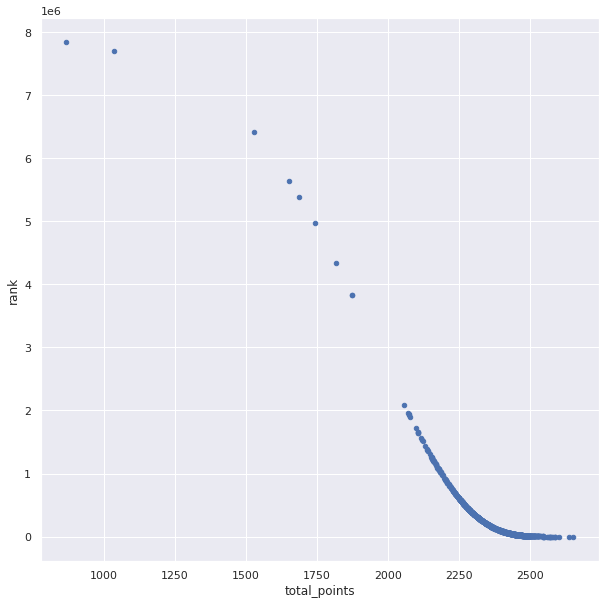

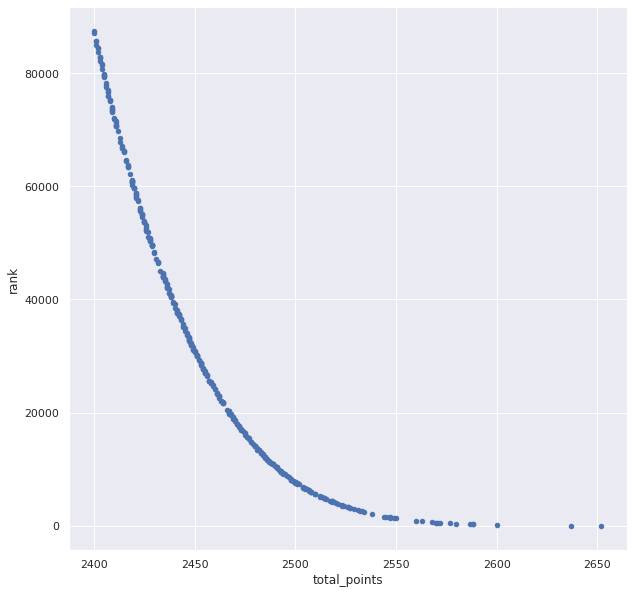

In [ ]:
def plot_top_managers(team_ids = range(1, 1000, 1)):
    sns.set()
    overall_dataframe = pd.DataFrame()
    for id in team_ids:
        previous_seasons = Access_URL(f'https://fantasy.premierleague.com/api/entry/{id}/history/')['past']
        df_player = pd.DataFrame(previous_seasons)
        df_player['id'] = id
        overall_dataframe = pd.concat([overall_dataframe, df_player])
    last_season = overall_dataframe.loc[overall_dataframe['season_name'] == '2020/21']
    last_season.plot(kind='scatter', x='total_points', y='rank', figsize=(10, 10))
    mask = (last_season['total_points'] >= 2400) 
    last_season.loc[mask].plot(kind='scatter', x='total_points', y='rank', figsize=(10, 10))
    return last_season

last_season =  plot_top_managers(team_ids = range(1, 1000, 1))

In [ ]:
df = pd.read_csv('./drive/MyDrive/Data/points_data.csv')
import seaborn as sns
import matplotlib.pyplot as plt
df.loc[(df['total_points'] > 2095) & (df['total_points'] < 2115) ]

,Unnamed: 0,season_name,total_points,rank,id
82,2,2020/21,2105.0,1654864.0,85
359,4,2020/21,2098.0,1714622.0,366
415,7,2020/21,2105.0,1656251.0,422
780,3,2020/21,2106.0,1644816.0,790
925,0,2020/21,2106.0,1644994.0,936
